In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [3]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

# DATA CLEANING 

In [4]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

In [5]:
df.rename(columns={'v1':'target', 'v2':'text'}, inplace=True)

In [6]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [7]:
df['target'] = encoder.fit_transform(df['target'])

In [8]:
df.isnull().sum()

target    0
text      0
dtype: int64

In [9]:
df.duplicated().sum()

np.int64(403)

In [10]:
df = df.drop_duplicates(keep='first')

# Exploratory Data Analysis(EDA)

In [11]:
df.head()

target                                               text
0       0  Go until jurong point, crazy.. Available only ...
1       0                      Ok lar... Joking wif u oni...
2       1  Free entry in 2 a wkly comp to win FA Cup fina...
3       0  U dun say so early hor... U c already then say...
4       0  Nah I don't think he goes to usf, he lives aro...

In [12]:
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

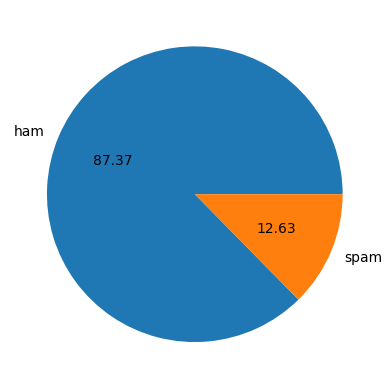

In [13]:
import matplotlib.pyplot as plt
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct="%0.2f")
plt.show()

In [14]:
import nltk

In [15]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rushi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
df['num_characters'] = df['text'].apply(len)

In [17]:
df['num_words'] = df['text'].apply(lambda x:len(nltk.wordpunct_tokenize(x)))

In [18]:
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [19]:
df.head()

target                                               text  num_characters  \
0       0  Go until jurong point, crazy.. Available only ...             111   
1       0                      Ok lar... Joking wif u oni...              29   
2       1  Free entry in 2 a wkly comp to win FA Cup fina...             155   
3       0  U dun say so early hor... U c already then say...              49   
4       0  Nah I don't think he goes to usf, he lives aro...              61   

   num_words  num_sentences  
0         24              2  
1          8              2  
2         39              2  
3         13              1  
4         16              1

In [20]:
import seaborn as sns

<Axes: xlabel='num_characters', ylabel='Count'>

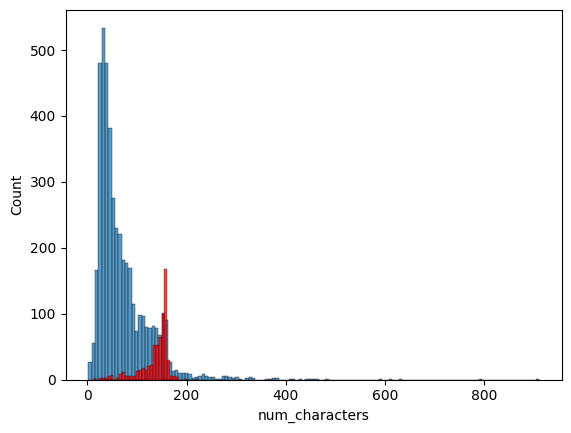

In [21]:
sns.histplot(df[df['target'] == 0]['num_characters'])
sns.histplot(df[df['target'] == 1]['num_characters'], color='red')

<Axes: xlabel='num_words', ylabel='Count'>

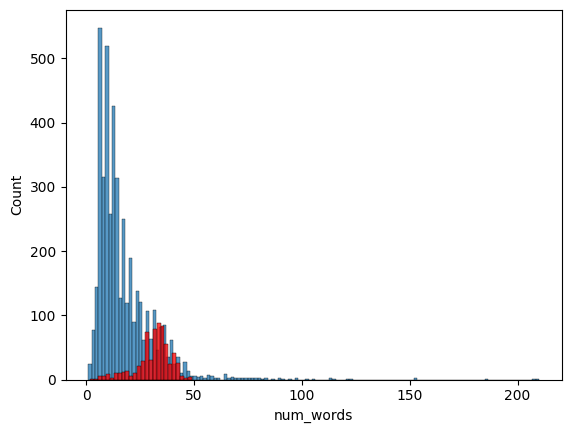

In [22]:
sns.histplot(df[df['target'] == 0]['num_words'])
sns.histplot(df[df['target'] == 1]['num_words'], color='red')

# DATA PREPROCESSING
  1. LOWER CASE
  2. TOKANIZATION
  3. REMOVING SPECIAL CHARACTERS
  4. REMOVING STOP WORDS AND PUNCTUATION
  5. STEMMING

In [23]:
from nltk.corpus import stopwords

In [24]:
import string 

In [25]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [26]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    y = []
    for i in text:
        if i.isalnum():
          y.append(i)
    
    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
        
    return " ".join(y)

In [27]:
df['transformed_text'] = df['text'].apply(transform_text)

In [28]:
df.head()

target                                               text  num_characters  \
0       0  Go until jurong point, crazy.. Available only ...             111   
1       0                      Ok lar... Joking wif u oni...              29   
2       1  Free entry in 2 a wkly comp to win FA Cup fina...             155   
3       0  U dun say so early hor... U c already then say...              49   
4       0  Nah I don't think he goes to usf, he lives aro...              61   

   num_words  num_sentences                                   transformed_text  
0         24              2  go jurong point crazi avail bugi n great world...  
1          8              2                              ok lar joke wif u oni  
2         39              2  free entri 2 wkli comp win fa cup final tkt 21...  
3         13              1                u dun say earli hor u c alreadi say  
4         16              1               nah think goe usf live around though

In [29]:
! pip install wordcloud

In [30]:
from wordcloud import WordCloud
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')

In [31]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

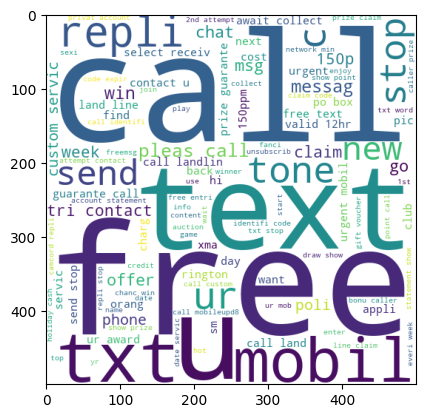

In [32]:
plt.imshow(spam_wc)

In [33]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))

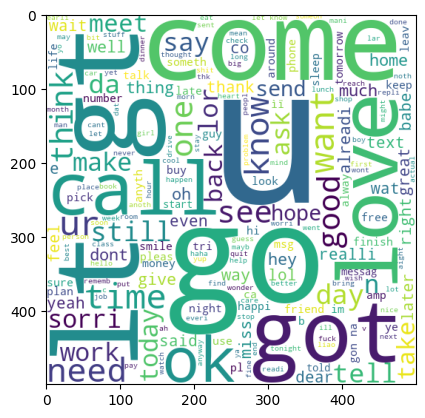

In [34]:
plt.imshow(ham_wc)

In [35]:
spam_corpus = []
for msg in df[df['target']==1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [36]:
len(spam_corpus)

9939

In [37]:
from collections import Counter
spam_counter = Counter(spam_corpus)
spam_common = pd.DataFrame(spam_counter.most_common(30), columns=['word', 'count'])

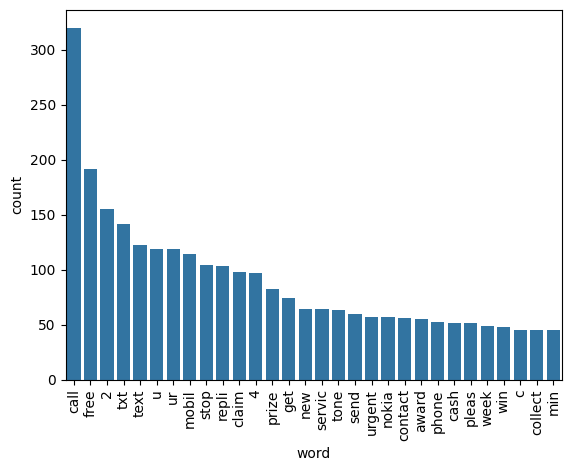

In [38]:
sns.barplot(x='word', y='count', data=spam_common)
plt.xticks(rotation=90)
plt.show()

In [39]:
ham_corpus = []
for msg in df[df['target']==0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

In [40]:
len(ham_corpus)

35404

In [41]:
ham_counter = Counter(spam_corpus)
ham_common = pd.DataFrame(ham_counter.most_common(30), columns=['word', 'count'])

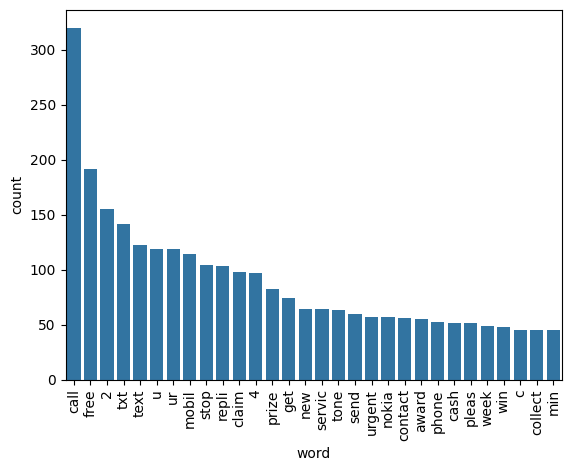

In [42]:
sns.barplot(x='word', y='count', data=ham_common)
plt.xticks(rotation=90)
plt.show()

# MODEL BUILDING

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(max_features=3000)

In [44]:
x = tf.fit_transform(df['transformed_text']).toarray()

In [45]:
x.shape

(5169, 3000)

In [46]:
y = df['target'].values

In [47]:
y

array([0, 0, 1, ..., 0, 0, 0])

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=2)

In [50]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

In [51]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [52]:
gnb.fit(x_train, y_train)
y_pred1 = gnb.predict(x_test)
print(accuracy_score(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))
print(precision_score(y_test, y_pred1))

0.874274661508704
[[790 106]
 [ 24 114]]
0.5181818181818182


In [53]:
mnb.fit(x_train, y_train)
y_pred2 = mnb.predict(x_test)
print(accuracy_score(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))
print(precision_score(y_test, y_pred2))

0.9709864603481625
[[896   0]
 [ 30 108]]
1.0


In [54]:
bnb.fit(x_train, y_train)
y_pred3 = bnb.predict(x_test)
print(accuracy_score(y_test, y_pred3))
print(confusion_matrix(y_test, y_pred3))
print(precision_score(y_test, y_pred3))

0.9835589941972921
[[895   1]
 [ 16 122]]
0.991869918699187


In [55]:
# So we choosed MultinomialNB because the precision_score is 1.0 and has good accuracy...

In [56]:
import pickle 
pickle.dump(tf, open('vectorizer.pkl', 'wb'))
pickle.dump(mnb, open('model.pkl', 'wb'))